In [1]:
## tools 
from langchain_core.tools import Tool
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [2]:
arxiv_wrapper=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper,
                description='Query arxiv papers')
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("attention all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)
print(wiki.name)

wikipedia


In [5]:
wiki.invoke('what is rnn')

'Page: Recurrent neural network\nSummary: In artificial neural networks, recurrent neural networks (RNNs) are designed for processing sequential data, such as text, speech, and time series, where the order of elements is important. Unlike feedforward neural networks, which process inputs independently, RNNs utilize recurrent connections, where the output of a neuron at one time step is fed back as input to the network at the next time step. This enables RNNs to capture temporal dependencies and pa'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")


In [7]:
## lets create tavily tool 
from langchain_community.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

C:\Users\Admin\AppData\Local\Temp\ipykernel_23632\2847010846.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [8]:
tavily.invoke('provide me tha recent ai news')

[{'title': 'Latest AI News May 2025 - 2026: What to Know - SoftCircles',
  'url': 'https://softcircles.com/blog/latest-ai-news-may-2025',
  'content': "The latest AI news May 2025 reveals an industry on an\nunprecedented growth trajectory, with the global AI market\nprojected to reach $4.8 trillion by 2033—marking a staggering\n25-fold increase from $189 billion in 2023. This explosive\nexpansion is mirrored in workplace adoption, where AI usage\nhas nearly doubled in U.S. businesses over just two years,\nclimbing from 21% to 40%. Additionally, daily employee AI use\nhas doubled from 4% to 8%, while weekly usage has surged from\n11% to 19%. [...] The latest ai news may 2025 shows that the first quarter of 2025\nmarked unprecedented investment in artificial intelligence, with\n$59.6 billion raised globally. AI secured $59.60 billion in\nglobal venture funding, representing 53% of all global funding\nduring this period. This investment surge reflects market\nconfidence in AI's long-term 

In [9]:
tools = [arxiv, wiki, tavily]

In [10]:
## initialize the llm model
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")

In [11]:
llm.invoke('What is AI')

AIMessage(content="<think>\nOkay, the user asked, What is AI? I need to explain AI in a clear and comprehensive way. First, I should define AI. AI stands for Artificial Intelligence, right? It's the simulation of human intelligence by machines. But what exactly does that mean? I should mention that it's a field of computer science focused on creating systems that can perform tasks typically requiring human intelligence. \n\nWait, what are the key aspects of AI? Maybe break it down into components like learning, reasoning, problem-solving, perception, and language understanding. Also, there's machine learning, which is a subset of AI. Oh, right, machine learning allows systems to learn from data without being explicitly programmed. I should explain that.\n\nThen there's deep learning, which is a type of machine learning using neural networks. Examples of AI applications would help clarify. Like, virtual assistants (Siri, Alexa), recommendation systems (Netflix, Amazon), self-driving car

In [12]:
llm_with_tools=llm.bind_tools(tools=tools)

In [13]:
llm_with_tools.invoke('What is computer vision')

AIMessage(content='Computer vision is a field of artificial intelligence (AI) that enables computers to process, analyze, and interpret visual information from the world, such as images, videos, or real-time camera input. Its goal is to replicate human visual perception and understanding, allowing machines to identify objects, detect patterns, recognize scenes, and make decisions based on visual data.\n\nKey applications include:\n- **Image recognition** (e.g., identifying objects or people in photos)\n- **Facial recognition** (e.g., unlocking smartphones or security systems)\n- **Autonomous vehicles** (e.g., detecting pedestrians, traffic signs, and obstacles)\n- **Medical imaging** (e.g., diagnosing diseases from X-rays or MRIs)\n- **Augmented reality** (e.g., overlaying digital elements onto the real world)\n\nTechnologies driving computer vision include **machine learning**, **deep learning** (e.g., convolutional neural networks), and specialized algorithms for tasks like edge dete

### workflow

In [14]:
## state schema 

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## could be human message or AI message
from typing import Annotated ## annotation measn labelling 
from langgraph.graph.message import add_messages ## reducers in langgraph

In [21]:
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

In [22]:
## Entire chatbot with langgraph 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

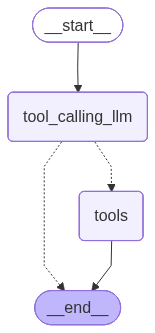

In [28]:
## node definition 

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph 
builder=StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

builder.add_edge("tools", END)

graph= builder.compile()

## view 
display(Image(graph.get_graph().draw_mermaid_png()))



In [26]:
from langchain_core.messages import HumanMessage
messages = graph.invoke({"messages":[HumanMessage(content="1706.03762")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (m60cmpsd8)
 Call ID: m60cmpsd8
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [27]:
messages = graph.invoke({"messages":[HumanMessage(content="hi my name is bhushan")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

hi my name is bhushan
================================== Ai Message ==================================

Hello Bhushan! How can I assist you today?


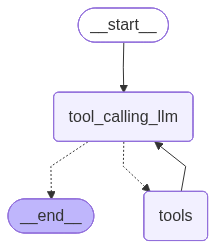

In [29]:
## node definition 

def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

#Build graph 
builder=StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)

builder.add_edge("tools", "tool_calling_llm")

graph= builder.compile()

## view 
display(Image(graph.get_graph().draw_mermaid_png()))


In [31]:
messages = graph.invoke({"messages":[HumanMessage(content="what is recent AI news and tell me the recent research paper on quantum computing")]})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is recent AI news and tell me the recent research paper on quantum computing
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (9y9g13g4j)
 Call ID: 9y9g13g4j
  Args:
    query: recent AI news
  arxiv (3k4v53ty0)
 Call ID: 3k4v53ty0
  Args:
    query: quantum computing
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The Latest AI News and AI Breakthroughs that Matter Most", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Date: December 14, 2025 Summary: OpenAI has announced the \"OpenAI Academy for News Organizations,\" a new initiative designed to provide journalists and media outlets with the tools and training necessary to integrate AI into their workflows. The program offers financial grants, technical support, and ac